In [1]:
library(Matrix)
u.data <- read.csv(file = 'data.csv', sep='|', header=T)
u.user <- read.csv(file = 'user.csv', sep='|', header=T)
u.item <- read.csv(file = 'item.csv', sep='|', header=T)

mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)
matrix.cos <- function(m) {
(m %*% t(m)) / ( t(matrix(sqrt(rowSums(m^2)),nrow(m),nrow(m)))*(sqrt(rowSums(m^2))))
}
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs((m - m.hat)[!is.na(m)]),na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
colMeans.sparse <- function(m) {colSums(m)/colSums(m>0)}
rowMeans.sparse <- function(m) {rowSums(m)/rowSums(m>0)}
means.sparse <- function(v) {sum(v)/sum(v>0)}


# Trouve les indexes des premieres 'n' valeurs maximales d'une matrice
max.nindex <- function(m, n=5) {
    i <- order(m, decreasing=TRUE)
    return(i[1:n])
}
# Trouve les indexes des premieres 'n' valeurs minimales d'une matrice
min.nindex <- function(m, n=5) {
    i <- order(m)
    return(i[1:n])
}
cosinus.vm <- function(v,m) { 
    n <- sqrt(colSums(m^2)); 
    (v %*% m)/(n * sqrt(sum(v^2)))
}

In [19]:
library(parallel)

In [2]:
m <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m) <- paste('u', 1:nrow(m), sep='')
colnames(m) <- paste('i', 1:ncol(m), sep='')
m <- as.matrix(m)
m.na <- m
m.full <- m
m.na[m==0] <- NA

In [3]:
u.mean <- matrix(rowMeans(m.na, na.rm=T), nrow(m), ncol(m))
item.mean <- matrix(colMeans(m.na, na.rm=T), nrow(m), ncol(m), byrow=T)
m.expect <- ((u.mean + item.mean)/2)
corner <- function(m, ...) head(t(tail(t(m), ...)), ...)
corner(m.expect)



"[1677,]","[1678,]","[1679,]","[1680,]","[1681,]","[1682,]"
3.305147,2.305147,3.305147,2.805147,3.305147,3.305147
3.354839,2.354839,3.354839,2.854839,3.354839,3.354839
2.898148,1.898148,2.898148,2.398148,2.898148,2.898148
3.666667,2.666667,3.666667,3.166667,3.666667,3.666667
2.937143,1.937143,2.937143,2.437143,2.937143,2.937143
3.317536,2.317536,3.317536,2.817536,3.317536,3.317536


performance minimal: moyenne des lignes et colonnes

In [4]:
mae(m.expect, m.na)

[1] 0.7825831

on remplie la matrice avec la moyenne des lignes et colonnes
on normalise la colone en divisant par 5 (la note maximale)

In [5]:
m.full[m==0] <- m.expect[m==0]
m.full.5 <- m.full/5
m.svd <- svd(m.full.5)

In [6]:
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2*5, m.na)
    }
new.m.mae.rmse(10)

$mae
[1] 0.6902685

$rmse
[1] 0.8720692

In [ ]:
new.m <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2*5, m.na)
    }
to.plot.1 <- lapply(seq(1,943,30), new.m)


In [ ]:
plot(seq(1,943,30),unlist(to.plot.1))

[1] 100000

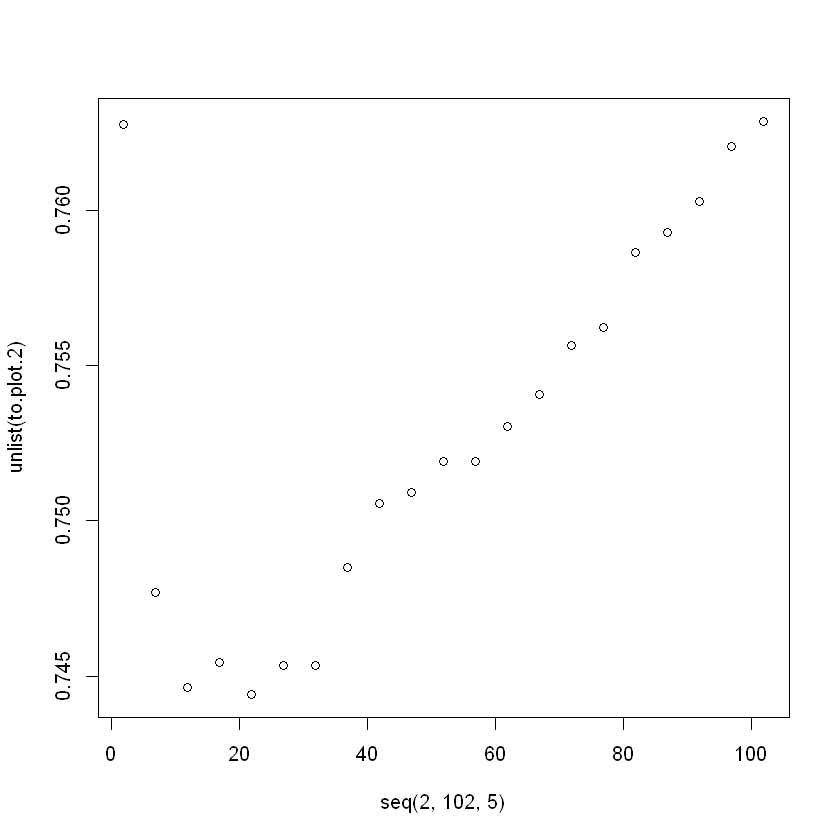

In [8]:
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
length(i.hasard)
fold.size <- round(length(i.hasard) / 10)
i.false <- rep(FALSE, length(m))
fold.number <- 1
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[m==0] <- m.expect[m==0]
m.train[i.test.b] <- m.expect[i.test.b]                # on enlève les données de test pour l'entraînement
m.train <- m.train/5
m.svd <- svd(m.train)

new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.b]*5, m.na[i.test.b])
    }
to.plot.2 <- lapply(seq(2,102,5), new.m.cv)
plot(seq(2,102,5),unlist(to.plot.2))

In [ ]:
# Question 7 - Validation croisée pour question 3
# Ici nous essayons de prédire les valeurs des votes du film Star trek 5 à l'aide d'une approche item-item

try <- function(x,y,w) {x.0 <- x>0 ; x.temp <- (x-y)*x.0; num <-  w %*%x.temp;denum <- sum(abs(t(w))*x.0);num/denum} 
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
m.sparse.t <- t(m.sparse)


film_pred <- function(film_id){
# Pour l'exercise, on choisit de prendre seulement les utilisateurs pour l'item Star Trek V: The Final Frontier
v.item <- m.sparse.t[film_id,]
# Le set est divisé en train set (80%) et test set (20%)
i <- u.user$id[v.item > 0]
i.test <- i
i.train <- ! i.test
i.test[sample(length(i),0.8*length(i))] <- FALSE
test <- i.test[i.test >0]
train <- i[! i.test >0]
new.m.sparse <- m.sparse
new.m.sparse[test,film_id] = 0

voisins <- 21
# on centre la matrice m selon les utilisateurs
# on calcule la moyenne et centré pour enlever les biais des utilisateurs comme pour la question 4
u.mean <-rowMeans.sparse(new.m.sparse)
m.center <- as.matrix((new.m.sparse-u.mean)*(new.m.sparse>0))
# on remplace les 0 par NA
m.center[m.center ==0] <- NA

# on calcule la distance eucledienne entre les films
distance.na.450.center <- sqrt(colSums((m.center[,film_id] - m.center)^2, na.rm=T)) # ignore les valeurs manquantes
# on calcule le nombre de votes communs des films avec star trek V
votes.communs <- (colSums((new.m.sparse[,film_id] * new.m.sparse) > 0))
# on assigne la valeur au film qui ont moins de 40 votes communs avec star trek V
distance.na.450.center[votes.communs<10] <- Inf

closest.euc <- min.nindex(distance.na.450.center, voisins)[-1]

wcos.st <- cosinus.vm(new.m.sparse[,film_id], new.m.sparse[,closest.euc])

# les 20 films les plus communs
idx<- closest.euc
# on transpose m
m.sparse.t <- t(new.m.sparse)
# la range de l item de star trek V
v.item <- m.sparse.t[film_id,]
# la moyenne de l item de star trek V
v_1 <-means.sparse(v.item);
# retourne la moyenne pour chacun des 20 films voisisns
v_i <- apply(m.sparse.t[idx,], 1, FUN=means.sparse)

x<- as.matrix((m.sparse.t[idx,]))
new_x <-lapply(seq_len(ncol(x)), function(i) x[,i]) # Retourne une liste de longeur 943 
new_y <-as.vector(lapply(seq_len(ncol(x)), function(i) v_i)) 
new_w <-as.vector(lapply(seq_len(ncol(x)), function(i) as.matrix(wcos.st)))

    
c_prod <- mapply(try ,new_x, new_y, new_w)
# Ajoute la moyenne de l'item 
v_1+c_prod
}
film_prection_list <-lapply(seq_len(1682), film_pred) # Retourne une liste de longeur 943 



In [20]:
# Question 7 - Validation croisée pour question 3
# Ici nous essayons de prédire les valeurs des votes du film Star trek 5 à l'aide d'une approche item-item
m.sparse <- m.train*5
m.sparse.t <- t(m.sparse)
try <- function(x,y,w) {x.0 <- x>0 ; x.temp <- (x-y)*x.0; num <-  w %*%x.temp;denum <- sum(abs(t(w))*x.0);num/denum} 

film_pred <- function(film_id){
# Pour l'exercise, on choisit de prendre seulement les utilisateurs pour l'item Star Trek V: The Final Frontier
v.item <- m.sparse.t[film_id,]
# Le set est divisé en train set (80%) et test set (20%)
new.m.sparse <- m.sparse

voisins <- 21
# on centre la matrice m selon les utilisateurs
# on calcule la moyenne et centré pour enlever les biais des utilisateurs comme pour la question 4
u.mean <-rowMeans.sparse(new.m.sparse)
m.center <- as.matrix((new.m.sparse-u.mean)*(new.m.sparse>0))
# on remplace les 0 par NA
m.center[m.center ==0] <- NA

# on calcule la distance eucledienne entre les films
distance.na.450.center <- sqrt(colSums((m.center[,film_id] - m.center)^2, na.rm=T)) # ignore les valeurs manquantes
# on calcule le nombre de votes communs des films avec star trek V
votes.communs <- (colSums((new.m.sparse[,film_id] * new.m.sparse) > 0))
# on assigne la valeur au film qui ont moins de 40 votes communs avec star trek V
distance.na.450.center[votes.communs<5] <- Inf

closest.euc <- min.nindex(distance.na.450.center, voisins)[-1]

wcos.st <- cosinus.vm(new.m.sparse[,film_id], new.m.sparse[,closest.euc])

# les 20 films les plus communs
idx<- closest.euc
# on transpose m
m.sparse.t <- t(new.m.sparse)
# la range de l item de star trek V
v.item <- m.sparse.t[film_id,]
# la moyenne de l item de star trek V
v_1 <-means.sparse(v.item);
# retourne la moyenne pour chacun des 20 films voisisns
v_i <- apply(m.sparse.t[idx,], 1, FUN=means.sparse)

x<- as.matrix((m.sparse.t[idx,]))
new_x <-lapply(seq_len(ncol(x)), function(i) x[,i]) # Retourne une liste de longeur 943 
new_y <-as.vector(lapply(seq_len(ncol(x)), function(i) v_i)) 
new_w <-as.vector(lapply(seq_len(ncol(x)), function(i) as.matrix(wcos.st)))

    
c_prod <- mapply(try ,new_x, new_y, new_w)
# Ajoute la moyenne de l'item 
v_1+c_prod
}
film_prection_list <-mclapply(seq_len(1682), film_pred) # Retourne une liste de longeur 943 



In [25]:
new.matrix <- do.call(cbind, film_prection_list)

In [26]:
mae(new.matrix[i.test.b], m.na[i.test.b])

[1] 0.7756795

In [27]:
dimRedu <- 14
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)

In [28]:
tmp <- m.svd2*5
tmp[is.na(t(new.matrix))] <- NA
mae(tmp[i.test.b], m.na[i.test.b])

[1] 0.745035